In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

data_dir = "./dataset"

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_data = datasets.ImageFolder(root=data_dir, transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(5):
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%")

torch.save(model.state_dict(), "tumor_classifier.pth")
 

/Users/himanshugupta/Documents/HimanshusProjects/Health/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/himanshugupta/Documents/HimanshusProjects/Health/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 3.8233, Accuracy: 75.49%
Epoch 2, Loss: 0.6311, Accuracy: 98.02%
Epoch 3, Loss: 0.1626, Accuracy: 100.00%
Epoch 4, Loss: 0.1606, Accuracy: 100.00%
Epoch 5, Loss: 0.0579, Accuracy: 100.00%


In [6]:
from PIL import Image

img_path = "./dataset/no/1 no.jpeg"
img = Image.open(img_path).convert("RGB")
img = transform(img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(img)
    pred = torch.argmax(output, 1).item()

print("Prediction:", "Tumor" if pred==1 else "No Tumor")


Prediction: No Tumor


100%|██████████| 10000/10000 [01:26<00:00, 115.12it/s]


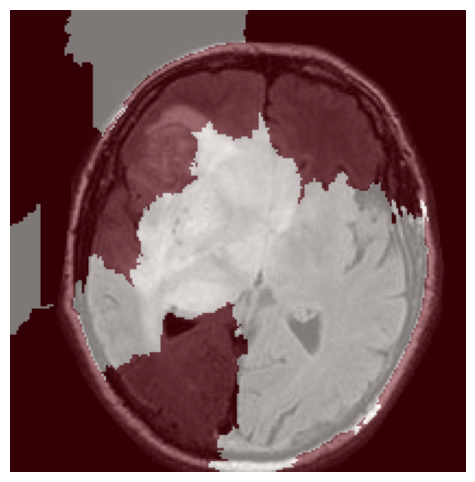

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

model.eval()

preprocess = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def predict(images):
    model.eval()
    batch = torch.stack([preprocess(Image.fromarray(img)) for img in images], dim=0)
    batch = batch.to(next(model.parameters()).device)
    with torch.no_grad():
        outputs = model(batch)
        probs = nn.Softmax(dim=1)(outputs)
    return probs.cpu().numpy()

img_path = "./dataset/yes/Y1.JPG"
img = Image.open(img_path).convert("RGB")
img = np.array(img)

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    img,
    predict,
    top_labels=2,
    hide_color=0,
    num_samples=10000
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis("off")
plt.show()
